In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings

import os
os.makedirs("../out", exist_ok=True)

from tqdm import tqdm

# Q2: Affine Motion Subtraction

Make sure to comment your code and use proper names for your variables.

## Q2.1: Lucas-Kanade Tracking with Affine Motion

In [12]:
# We recommend using this function, but you can explore other methods as well (e.g., ndimage.shift).
from scipy.interpolate import RectBivariateSpline as RBS

# The function below could be useful as well :) 
from numpy.linalg import lstsq

def LucasKanadeAffine(It, It1, threshold, num_iters):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : If the length of dp < threshold, terminate the optimization
    :param[int] num_iters       : Number of iterations for running the optimization

    :return[np.array(2, 3)] M   : Affine warp matrix
    """
    # Initial M
    # M = np.eye(3)
    # M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])
    p = np.zeros(6)
    dp_thresh = 1
    i = 0
    
    It_spline = RBS(np.arange(It.shape[0]), np.arange(It.shape[1]), It)
    It1_spline = RBS(np.arange(It1.shape[0]), np.arange(It1.shape[1]), It1)
    
    # ----------------------------------------------------------------------------------------------
    # TODO: Add your LK implementation here: 
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    x = np.linspace(0, It1.shape[1], It1.shape[1])
    y = np.linspace(0, It1.shape[0], It1.shape[0])

    x_mesh, y_mesh = np.meshgrid(x, y)

    # It1_y, It1_x = np.gradient(It1)

    # It1_grad_spline_x = RBS(x, y, It1_x)
    # It1_grad_spline_y = RBS(x, y, It1_y)


    while (i <= num_iters) and (dp_thresh >= threshold):        
        x_warped = (1 + p[0]) * x_mesh + p[1] * y_mesh + p[2]
        y_warped = p[3] * x_mesh + (1 + p[4]) * y_mesh + p[5]

        #Determining indices that meet the conditions         
        # idx_valid1 = (x_warped >= 0)
        # idx_valid2 = (x_warped <= It.shape[1])
        # idx_valid_x = (idx_valid1 == idx_valid2)
        
        # idx_valid3 = (y_warped >= 0)
        # idx_valid4 = (y_warped <= It.shape[0])
        # idx_valid_y = (idx_valid3 == idx_valid4)
        
        # idx_valid = (idx_valid_x == idx_valid_y)

        idx_valid = (x_warped > 0) & (x_warped < It.shape[1]) & (y_warped > 0) & (y_warped < It.shape[0])

        # break
        # x_warped_valid = x_warped[idx_valid]
        # y_warped_valid = y_warped[idx_valid]
        
        It1_inter = It1_spline.ev(y_warped[idx_valid], x_warped[idx_valid]).flatten()
        # print(It1_inter.shape)
        
        It1_grad_x = It1_spline.ev(y_warped[idx_valid], x_warped[idx_valid], dx = 1, dy = 0).flatten()
        It1_grad_y = It1_spline.ev(y_warped[idx_valid], x_warped[idx_valid], dx = 0, dy = 1).flatten()
        
        # It1_grad_x = It1_grad_spline_x.ev(y_warped_valid, x_warped_valid)
        # It1_grad_y = It1_grad_spline_y.ev(y_warped_valid, x_warped_valid)
        # It1_grad = np.vstack((It1_grad_y, It1_grad_x)).T
        
        A = np.zeros((It1_grad_x.shape[0], 6))
        #dW/dp = [x y 1 0 0 0;
        #         0 0 0 x y 1]
        
        # dW = np.array([[x_mesh.flatten(), 0, y_mesh.flatten(), 0, 1, 0 ], [0, x_mesh.flatten(), 0, y_mesh.flatten(), 0, 1]], dtype = object)
        
        A[:, 0] = It1_grad_y @ x_mesh[idx_valid].flatten()
        A[:, 1] = It1_grad_y @ y_mesh[idx_valid].flatten()
        A[:, 2] = It1_grad_y 

        A[:, 3] = It1_grad_x @ x_mesh[idx_valid].flatten()
        A[:, 4] = It1_grad_x @ y_mesh[idx_valid].flatten()
        A[:, 5] = It1_grad_x

        # print("A:", A)
        
        It_inter = It_spline.ev(y_mesh[idx_valid], x_mesh[idx_valid]).flatten()
        b = It_inter - It1_inter
        # print("b", b)
        
        delta_p, _,_, _ = lstsq(A, b, rcond = None)

        dp_thresh = np.linalg.norm(delta_p)
        
        # if (dp_thresh < threshold):
        #     print('Below threshold')
        #     print(delta_p)
        

        p += delta_p
        i += 1

    M = np.array([[1 + p[0], p[1], p[2]], [p[3], 1 + p[4], p[5]]])
    # breakpoint()
    # ----------------------------------------------------------------------------------------------
    return M

# Q2.2: Dominant Motion Subtraction

In [13]:
# These functions could be useful for your implementation. 
from scipy.ndimage import binary_erosion, binary_dilation, affine_transform
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : For LucasKanadeAffine --> If the length of dp < threshold, 
                                  terminate the optimization
    :param[int] num_iters       : For LucasKanadeAffine --> Number of iterations for running the 
                                  optimization
    :param[float] tolerance     : Binary threshold of intensity difference when computing the mask.
   
    :return[np.array(H, W)] mask: Binary mask indicating moving pixels. 
    """
    mask = np.ones(It1.shape, dtype=bool)

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your code here:
    M = LucasKanadeAffine(It, It1, threshold, num_iters)
    # print("Caculated M:", M1)
    # M2= cv2.getAffineTransform(It, It1)
    # print("cv2 M:", M2)
    # print(It.shape)
    It_warp = cv2.warpAffine(It, M, It1.T.shape)

    # print("It warp shape:", It_warp.shape)
    # print("It1 shape:", It1.shape)
    
    error = np.absolute(It1 - It_warp)
    # print(error)
    mask = error > tolerance #Locations where movement occurs
    
    mask = binary_dilation(mask, iterations = 5)
    mask = binary_erosion(mask, iterations = 5)
    
    # ----------------------------------------------------------------------------------------------
    return mask 

## Q2.3: Track Sequence

In [14]:
def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] threshold       : If the length of dp < threshold, terminate the optimization
    :param[float] tolerance       : Binary threshold of intensity difference when computing the mask.

    :return[np.array(H, W)] mask: Binary mask indicating moving pixels.
    """
    # H, W, N = seq.shape
    # print(seq.shape)

    masks = np.zeros(seq.shape, dtype = bool)
    # print(masks.shape)
    # It = seq[:, :, 0]
    

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your code here:
    for i in tqdm(range(1, seq.shape[2])):
        It = seq[:, :, i-1]
        It1 = seq[:, :, i]
        
        mask = SubtractDominantMotion(It, It1, num_iters, threshold, tolerance)
        # print(mask.shape)
        masks[:, :, i] = mask
        # It = It1

    # ----------------------------------------------------------------------------------------------

    # print(masks.shape)
    return masks

### Q2.3: Track Ant Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [21]:
seq = np.load("../data/antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 100
threshold = 1e-2
tolerance = 0.1

masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
np.save(f'../out/antseqmasks.npy', masks)

100%|██████████| 124/124 [00:25<00:00,  4.87it/s]


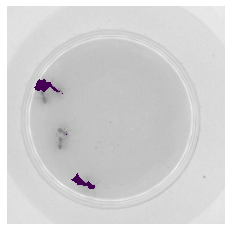

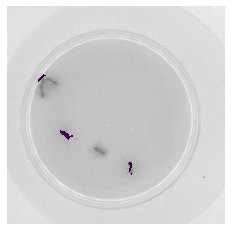

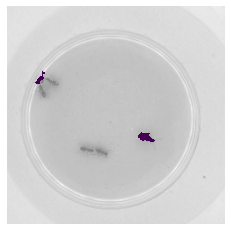

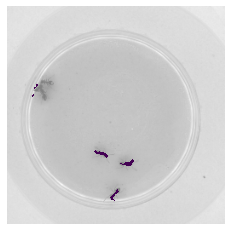

In [25]:
# TODO: visualize
frames_to_save = [29, 59, 89, 119]

masks = np.load('../out/antseqmasks.npy')
# print(masks.shape)
# print(seq[:, :, 29].shape)

# plt.imshow(seq[:, :, 29], cmap="gray", alpha=0.5)

for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]
    # print(mask.shape)
   
    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"../out/sol_2.3_antseq_{idx+1}.png")

### Q2.3: Test Aerial Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [34]:
seq_aerial = np.load("../data/aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 100
threshold = 1e-2
tolerance = 0.1

masks_aerial = TrackSequenceAffineMotion(seq_aerial, num_iters, threshold, tolerance)
np.save(f'../out/aerialseqmasks.npy', masks_aerial)

100%|██████████| 149/149 [02:17<00:00,  1.08it/s]


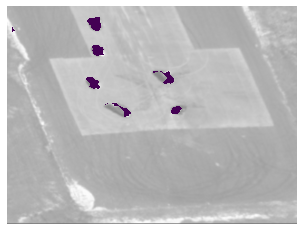

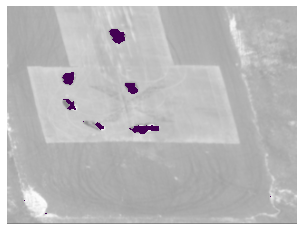

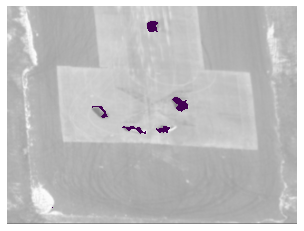

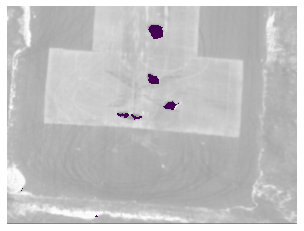

In [35]:
# TODO: visualize
frames_to_save = [29, 59, 89, 119]

masks_aerial = np.load('../out/aerialseqmasks.npy')

for idx in frames_to_save:
    frame = seq_aerial[:, :, idx]
    mask = masks_aerial[:, :, idx]
    # print(mask.shape)
   
    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"../out/sol_2.3_aerialseq_{idx+1}.png")

In [19]:
#Logic test
x = np.arange(4)
print(x)

valid = x > 0
print(valid)
print(x[valid])

x_stack = np.stack(np.reshape(x, (2,2)), axis = 1)

print(x_stack)

[0 1 2 3]
[False  True  True  True]
[1 2 3]
[[0 2]
 [1 3]]
